In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import scipy.stats
from scipy.stats import linregress

import cftime


In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
"ERA-Interim": 
    Dataset(
    short_name='tos',
    dataset='ERA-Interim',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20190101",
    tier=3)
}

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [11]:
def prepoc(cube):
    nino34_latext_region = {"start_longitude": 120., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
#    cube = area_statistics(cube,operator='mean')
    cube = axis_statistics(cube,axis='y', operator='mean')
#    cube = extract_month(cube,12) # get DEC
    return cube


In [12]:
model_datasets_prep = {name: prepoc(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: prepoc(dataset) for name, dataset in obs_datasets.items()}


In [13]:
model_n34 = model_datasets_prep["ACCESS-ESM1-5"]

obs_n34 = obs_datasets_prep["HadISST"]


In [15]:
# Create a CubeList with both cubes
combined_cubes = iris.cube.CubeList([model_n34])

# Save the CubeList to a single NetCDF file
output_filepath = '/g/data/p66/ars599/Hackathon/ENSO_recipes/n34_lontime_combined.nc'

iris.save(combined_cubes, output_filepath, netcdf_format="NETCDF4")


# Create a CubeList with both cubes
combined_cubes = iris.cube.CubeList([obs_n34])

# Save the CubeList to a single NetCDF file
output_filepath = '/g/data/p66/ars599/Hackathon/ENSO_recipes/n34_lontime_combined_obs.nc'

iris.save(combined_cubes, output_filepath, netcdf_format="NETCDF4")

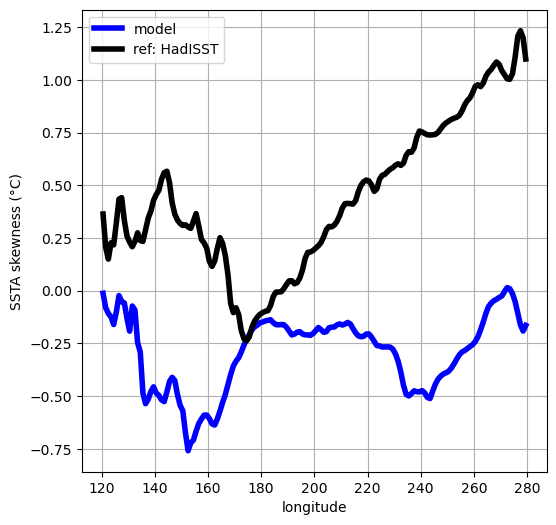

In [22]:
from scipy.stats import skew

# Load the dataset
output_filepath = '/g/data/p66/ars599/Hackathon/ENSO_recipes/n34_lontime_combined.nc'
model_ds = xr.open_dataset(output_filepath)
model_n34 = model_ds['tos'].squeeze()
output_filepath = '/g/data/p66/ars599/Hackathon/ENSO_recipes/n34_lontime_combined_obs.nc'
obs_ds = xr.open_dataset(output_filepath)
obs_n34 = obs_ds['tos'].squeeze()

# Convert n34 to a NumPy array
model_n34_np = model_n34.values  # Convert to a NumPy array
obs_n34_np = obs_n34.values  # Convert to a NumPy array

# Calculate the standard deviation across the 0th axis (for each month)
model_skew_dev = skew(model_n34, axis=0)
obs_skew_dev = skew(obs_n34, axis=0)

# Create the plot
plt.figure(figsize=(6, 6))
plt.plot(model_ds.lon, model_skew_dev, c='b', linewidth=4, label='model')
plt.plot(obs_ds.lon, obs_skew_dev, c='k', linewidth=4, label='ref: HadISST')

# Set the x and y axis labels
plt.xlabel('longitude')
plt.ylabel('SSTA skewness (°C)')
plt.grid(); plt.legend()
